## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [ ]:
model.add(keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [ ]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
E0213 19:12:55.493896 4621630912 program.py:311] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

In [ ]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 9s 5ms/step - loss: 9.4191 - accuracy: 0.1388 - val_loss: 2.2328 - val_accuracy: 0.2040
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 2.1097 - accuracy: 0.2317 - val_loss: 2.0485 - val_accuracy: 0.2402
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.9667 - accuracy: 0.2844 - val_loss: 1.9681 - val_accuracy: 0.2964
Epoch 4/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.8740 - accuracy: 0.3149 - val_loss: 1.9178 - val_accuracy: 0.3254
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.8064 - accuracy: 0.3423 - val_loss: 1.8256 - val_accuracy: 0.3384
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.7525 - accuracy: 0.3595 - val_loss: 1.7430 - val_accuracy: 0.3692
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.7116 - accuracy: 0.3819 - val_loss: 1.7199 - val_ac

In [ ]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.4960 - accuracy: 0.4762


[1.4960416555404663, 0.47620001435279846]

The model with the lowest validation loss gets about 47.6% accuracy on the validation set. It took 27 epochs to reach the lowest validation loss, with roughly 8 seconds per epoch on my laptop (without a GPU). Let's see if we can improve performance using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 19s 9ms/step - loss: 1.9765 - accuracy: 0.2968 - val_loss: 1.6602 - val_accuracy: 0.4042
Epoch 2/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.6787 - accuracy: 0.4056 - val_loss: 1.5887 - val_accuracy: 0.4304
Epoch 3/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.6097 - accuracy: 0.4274 - val_loss: 1.5781 - val_accuracy: 0.4326
Epoch 4/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.5574 - accuracy: 0.4486 - val_loss: 1.5064 - val_accuracy: 0.4676
Epoch 5/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.5075 - accuracy: 0.4642 - val_loss: 1.4412 - val_accuracy: 0.4844
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4664 - accuracy: 0.4787 - val_loss: 1.4179 - val_accuracy: 0.4984
Epoch 7/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4334 - accuracy: 0.4932 - val_loss: 1.4277 -

[1.3343921899795532, 0.5397999882698059]

* *Is the model converging faster than before?* Much faster! The previous model took 27 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 5 epochs and continued to make progress until the 16th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 54.0% accuracy instead of 47.6%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 12s instead of 8s, because of the extra computations required by the BN layers. But overall the training time (wall time) was shortened significantly!

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 10s 5ms/step - loss: 2.0622 - accuracy: 0.2631 - val_loss: 1.7878 - val_accuracy: 0.3552
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.7328 - accuracy: 0.3830 - val_loss: 1.7028 - val_accuracy: 0.3828
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.6342 - accuracy: 0.4279 - val_loss: 1.6692 - val_accuracy: 0.4022
Epoch 4/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5524 - accuracy: 0.4538 - val_loss: 1.6350 - val_accuracy: 0.4300
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4979 - accuracy: 0.4756 - val_loss: 1.5773 - val_accuracy: 0.4356
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4428 - accuracy: 0.4902 - val_loss: 1.5529 - val_accuracy: 0.4630
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3966 - accuracy: 0.5126 - val_loss: 1.5290 - val_a

[1.4633383750915527, 0.47920000553131104]

In [ ]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.4633 - accuracy: 0.4792


[1.4633383750915527, 0.47920000553131104]

We get 47.9% accuracy, which is not much better than the original model (47.6%), and not as good as the model using batch normalization (54.0%). However, convergence was almost as fast as with the BN model, plus each epoch took only 7 seconds. So it's by far the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 9s 5ms/step - loss: 2.0583 - accuracy: 0.2742 - val_loss: 1.7429 - val_accuracy: 0.3858
Epoch 2/100
1407/1407 [==============================] - 6s 5ms/step - loss: 1.6852 - accuracy: 0.4008 - val_loss: 1.7055 - val_accuracy: 0.3792
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5963 - accuracy: 0.4413 - val_loss: 1.7401 - val_accuracy: 0.4072
Epoch 4/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5231 - accuracy: 0.4634 - val_loss: 1.5728 - val_accuracy: 0.4584
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4619 - accuracy: 0.4887 - val_loss: 1.5448 - val_accuracy: 0.4702
Epoch 6/100
1407/1407 [==============================] - 6s 5ms/step - loss: 1.4074 - accuracy: 0.5061 - val_loss: 1.5678 - val_accuracy: 0.4664
Epoch 7/100
1407/1407 [==============================] - 6s 5ms/step - loss: 1.3718 - accuracy: 0.5222 - val_loss: 1.5764 - val_ac

[1.4804893732070923, 0.48899999260902405]

The model reaches 48.9% accuracy on the validation set. That's very slightly better than without dropout (47.6%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [ ]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4892

We get no accuracy improvement in this case (we're still at 48.9% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.1255


(9.999999747378752e-06,
 9.999868392944336,
 2.6167492866516113,
 3.9354368618556435)

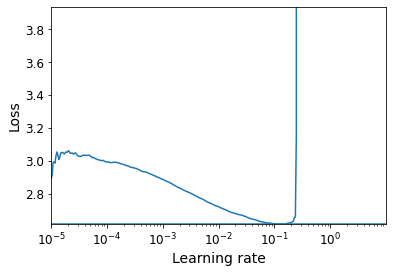

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 6ms/step - loss: 2.2298 - accuracy: 0.2349 - val_loss: 1.7841 - val_accuracy: 0.3834
Epoch 2/15
352/352 [==============================] - 2s 6ms/step - loss: 1.7928 - accuracy: 0.3689 - val_loss: 1.6806 - val_accuracy: 0.4086
Epoch 3/15
352/352 [==============================] - 2s 6ms/step - loss: 1.6475 - accuracy: 0.4190 - val_loss: 1.6378 - val_accuracy: 0.4350
Epoch 4/15
352/352 [==============================] - 2s 6ms/step - loss: 1.5428 - accuracy: 0.4543 - val_loss: 1.6266 - val_accuracy: 0.4390
Epoch 5/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4865 - accuracy: 0.4769 - val_loss: 1.6158 - val_accuracy: 0.4384
Epoch 6/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4339 - accuracy: 0.4866 - val_loss: 1.5850 - val_accuracy: 0.4412
Epoch 7/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4042 - accuracy: 0.5056 - val_loss: 1.6146 - val_accuracy: 0.4384
Epoch 

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 47.6% to 52.0%). The batch normalized model reaches a slightly better performance (54%), but it's much slower to train.